# Die Stimmungserkennung (SER)

## Inhalt

* [Tensorboard](#Tensorboard)
* [Python-Bibliotheken](#Bibliotheken)
* [Die Vorverarbeitung](#Vorverarbeitung)  
    * [Die Datenbeladung](#Datenbeladung)    
    * [Die Datenvisualisierung](#datenvisual)
* [Das Klassifikationsmodell](#klassifikationsmodell)
    * [Die Modellskonfiguration](#modelskonfiguration)
    * [Die Modellstruktur](#modellstruktur)
    * [Modell-Training](#modelltraining)
* [Save Modell](#savemodell)
* [Test Modell](#testmodell)
    * [Die Ganauigkeit](#ganauigkeit)
    * [Die Metriken](#metriken)

## Tensorboard<a class="anchor" id="Tensorboard"></a>

#### Tensorboard ist eine Webanwendung zur Visualisierungverschidener Aspekte neuronaler Netze

In [1]:
from keras.backend import clear_session
clear_session()
%reload_ext tensorboard

## Python-Bibliotheken<a class="anchor" id="Bibliotheken"></a>

In [2]:
import torch
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from torchvision import models, transforms
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torchvision
from functools import partial
import keras
import itertools
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from PIL import Image
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import StratifiedKFold
import os

## Die Vorverarbeitung<a class="anchor" id="Vorverarbeitung"></a>

In [7]:
# "surprise" wird von 8 auf 0 geändert
EMOTIONS = {0:'neutral', 1:'happy', 2:'sad', 3:'angry', 4:'fear', 5:'surprise'} 

In [3]:
path_model = Path.cwd() / "modell" / "audio_model.h5"
PATH_TO_RAVDESS = Path.cwd() /"frequenzbereich"
PATH_RAVDESS_TRAIN = PATH_TO_RAVDESS / "train"
PATH_RAVDESS_TEST = Path.cwd() / "test"
bs = 1440

In [8]:
# Confusion Matrix
class_names = [EMOTIONS[ind] for ind in range(len(EMOTIONS))]
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix (Keras ResNet - Modell)',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
  #      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 #   print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Die Datenbeladung<a class="anchor" id="Datenbeladung"></a>

In [4]:
class PrecomputedRavdess(Dataset):
    def __init__(self,path,dpi=50, img_transforms=None):
        files = Path(path).glob('{}{}*.wav.png'.format(path.name, dpi))
        self.items = [(f,int(f.name.split("-")[2].replace(".wav.png",""))) for f in files]
        self.length = len(self.items)
        if img_transforms == None:
            self.img_transforms = transforms.Compose([transforms.ToTensor()])
        else:
            self.img_transforms = img_transforms
    
    def __getitem__(self, index):
        
        filename, label = self.items[index]
        img = Image.open(filename).convert('RGB')# convert image to (YCbCr)YUL
        return (self.img_transforms(img), label)

            
    def __len__(self):
        return self.length

In [10]:
def LoadRavdess():

    ravdess = PrecomputedRavdess(PATH_RAVDESS_TRAIN,
                                  img_transforms=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])]))



    ravdess_loader = torch.utils.data.DataLoader(ravdess, bs, shuffle=True)

    spectogram = torch.utils.data.DataLoader(ravdess,64,shuffle=True )         
    return ravdess_loader, spectogram

In [11]:
ravdess_loader,spectogram = LoadRavdess()

### Die Datenvisualisierung<a class="anchor" id="#datenvisual"></a>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Labels: tensor([3, 3, 3, 3, 3, 1, 1, 4, 2, 4, 0, 3, 5, 5, 1, 5, 5, 4, 1, 2, 3, 2, 4, 2,
        5, 2, 3, 5, 2, 0, 5, 4, 5, 5, 1, 1, 2, 0, 1, 1, 1, 1, 4, 2, 0, 4, 3, 5,
        1, 0, 4, 2, 5, 2, 1, 0, 0, 3, 1, 2, 1, 0, 3, 4])


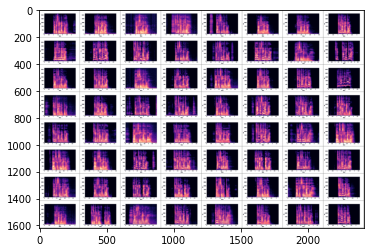

In [12]:
def imshow(img):
     img = img / 2 + 0.5
     npimg = img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()
img, label = next(iter(spectogram))       
images, labels = next(iter(ravdess_loader))  

print("Train Labels:",label)
imshow(torchvision.utils.make_grid(img)/2)

In [13]:
labels.shape

torch.Size([1151])

In [14]:
# Cross-validate
kf = StratifiedKFold(5, shuffle=True,random_state=42)

## Das Klassifikationsmodell<a class="anchor" id="#klassifikationsmodell"></a>

### Die Modellskonfiguration<a class="anchor" id="#modelskonfiguration"></a>

In [5]:
batch_size = 64
img_width, img_height, img_num_channels = 3,200,300
loss_function = sparse_categorical_crossentropy
no_classes = 6
optimizer = Adam()
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [6]:
# Residual Unit-Schicht
# Im Konstruktor werden alle erforderlichen Schichten erzeugt
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [7]:
#Das ResNet-34 kann mit einem Sequential-Modell angebaut werden.
def build_model():
    model = keras.models.Sequential()
    model.add(DefaultConv2D(64, kernel_size=3, strides=1,
                        input_shape= input_shape ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 7
    for filters in [64] * 1 + [128] * 1 + [256] * 1: 
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(no_classes, activation="softmax"))
    optimizer = keras.optimizers.Nadam(learning_rate=1e-3)
    model.compile(loss=loss_function,
              optimizer=optimizer,  metrics=['accuracy'])
    return model

In [18]:
# Datentyp-Umwandelung
images = (tf.cast(images, tf.float32) / 255).numpy()
labels = labels.numpy()

### Die Modellstruktur<a class="anchor" id="#modellstruktur"></a>

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 3, 200, 64)        172800    
_________________________________________________________________
batch_normalization (BatchNo (None, 3, 200, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 3, 200, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 100, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 1, 50, 64)         78592     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 1, 25, 128)        230912    
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 1, 13, 256)        9

Fold #1
Epoch 1/50
15/15 [==============================] - 11s 580ms/step - loss: 1.7664 - accuracy: 0.2546 - val_loss: 1.7933 - val_accuracy: 0.1645
Epoch 2/50
15/15 [==============================] - 7s 484ms/step - loss: 1.4865 - accuracy: 0.3961 - val_loss: 1.7938 - val_accuracy: 0.1645
Epoch 3/50
15/15 [==============================] - 7s 473ms/step - loss: 1.2208 - accuracy: 0.5438 - val_loss: 1.8035 - val_accuracy: 0.1645
Epoch 4/50
15/15 [==============================] - 7s 485ms/step - loss: 1.0668 - accuracy: 0.5805 - val_loss: 1.8193 - val_accuracy: 0.2121
Epoch 5/50
15/15 [==============================] - 7s 470ms/step - loss: 0.8985 - accuracy: 0.6305 - val_loss: 1.8457 - val_accuracy: 0.1645
Epoch 6/50
15/15 [==============================] - 7s 474ms/step - loss: 0.7101 - accuracy: 0.7372 - val_loss: 1.8918 - val_accuracy: 0.1645
Epoch 7/50
15/15 [==============================] - 7s 469ms/step - loss: 0.5100 - accuracy: 0.8208 - val_loss: 2.0697 - val_accuracy: 0.16

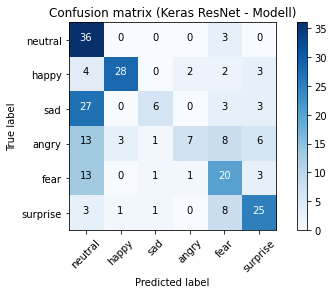

Fold score (accurancy): 0.5281385281385281
Fold #2
Epoch 1/50
15/15 [==============================] - 8s 501ms/step - loss: 1.4191 - accuracy: 0.5266 - val_loss: 139.3022 - val_accuracy: 0.1652
Epoch 2/50
15/15 [==============================] - 7s 487ms/step - loss: 0.9691 - accuracy: 0.6384 - val_loss: 64.0566 - val_accuracy: 0.1652
Epoch 3/50
15/15 [==============================] - 7s 486ms/step - loss: 0.6715 - accuracy: 0.7633 - val_loss: 27.5397 - val_accuracy: 0.1696
Epoch 4/50
15/15 [==============================] - 7s 483ms/step - loss: 0.4677 - accuracy: 0.8328 - val_loss: 14.0118 - val_accuracy: 0.1652
Epoch 5/50
15/15 [==============================] - 7s 490ms/step - loss: 0.3544 - accuracy: 0.8719 - val_loss: 8.0644 - val_accuracy: 0.2043
Epoch 6/50
15/15 [==============================] - 7s 499ms/step - loss: 0.3079 - accuracy: 0.8849 - val_loss: 5.1000 - val_accuracy: 0.2609
Epoch 7/50
15/15 [==============================] - 7s 492ms/step - loss: 0.2486 - accuracy:

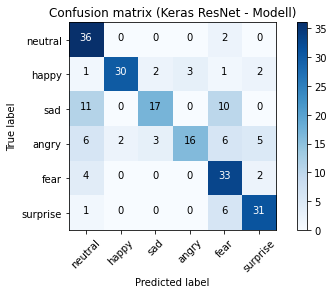

Fold score (accurancy): 0.7086956521739131
Fold #3
Epoch 1/50
15/15 [==============================] - 8s 545ms/step - loss: 0.4320 - accuracy: 0.8643 - val_loss: 5.3606 - val_accuracy: 0.4435
Epoch 2/50
15/15 [==============================] - 8s 509ms/step - loss: 0.1884 - accuracy: 0.9381 - val_loss: 2.6524 - val_accuracy: 0.5783
Epoch 3/50
15/15 [==============================] - 7s 491ms/step - loss: 0.0755 - accuracy: 0.9794 - val_loss: 5.2096 - val_accuracy: 0.3870
Epoch 4/50
15/15 [==============================] - 7s 477ms/step - loss: 0.0472 - accuracy: 0.9946 - val_loss: 2.5259 - val_accuracy: 0.5739
Epoch 5/50
15/15 [==============================] - 7s 470ms/step - loss: 0.0246 - accuracy: 0.9913 - val_loss: 4.0804 - val_accuracy: 0.3304
Epoch 6/50
15/15 [==============================] - 7s 469ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.0120 - val_accuracy: 0.6739
Epoch 7/50
15/15 [==============================] - 7s 468ms/step - loss: 0.0042 - accuracy: 1.00

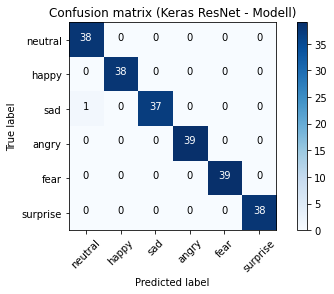

Fold score (accurancy): 0.9956521739130435
Fold #4
Epoch 1/50
15/15 [==============================] - 7s 479ms/step - loss: 0.0089 - accuracy: 0.9978 - val_loss: 0.5973 - val_accuracy: 0.8087
Epoch 2/50
15/15 [==============================] - 7s 470ms/step - loss: 0.0058 - accuracy: 1.0000 - val_loss: 0.6576 - val_accuracy: 0.7913
Epoch 3/50
15/15 [==============================] - 7s 470ms/step - loss: 0.0073 - accuracy: 0.9989 - val_loss: 1.1957 - val_accuracy: 0.6652
Epoch 4/50
15/15 [==============================] - 7s 469ms/step - loss: 0.0841 - accuracy: 0.9685 - val_loss: 5.1820 - val_accuracy: 0.3957
Epoch 5/50
15/15 [==============================] - 8s 520ms/step - loss: 0.3508 - accuracy: 0.8860 - val_loss: 22.1310 - val_accuracy: 0.2783
Epoch 6/50
15/15 [==============================] - 7s 471ms/step - loss: 0.2448 - accuracy: 0.9186 - val_loss: 19.6501 - val_accuracy: 0.1696
Epoch 7/50
15/15 [==============================] - 7s 470ms/step - loss: 0.0816 - accuracy: 0.

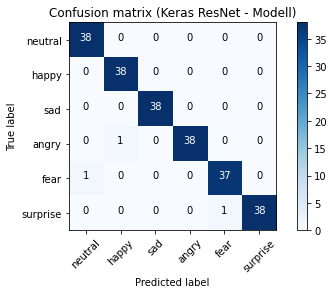

Fold score (accurancy): 0.9869565217391304
Fold #5
Epoch 1/50
15/15 [==============================] - 8s 535ms/step - loss: 0.0340 - accuracy: 0.9946 - val_loss: 2.3897 - val_accuracy: 0.5348
Epoch 2/50
15/15 [==============================] - 7s 495ms/step - loss: 0.0227 - accuracy: 0.9946 - val_loss: 0.3729 - val_accuracy: 0.8783
Epoch 3/50
15/15 [==============================] - 7s 495ms/step - loss: 0.0124 - accuracy: 0.9989 - val_loss: 0.9317 - val_accuracy: 0.6957
Epoch 4/50
15/15 [==============================] - 8s 506ms/step - loss: 0.0151 - accuracy: 0.9946 - val_loss: 0.2693 - val_accuracy: 0.8870
Epoch 5/50
15/15 [==============================] - 7s 486ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.3794 - val_accuracy: 0.6435
Epoch 6/50
15/15 [==============================] - 7s 475ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.2209 - val_accuracy: 0.6739
Epoch 7/50
15/15 [==============================] - 7s 492ms/step - loss: 0.0099 - accuracy: 0.99

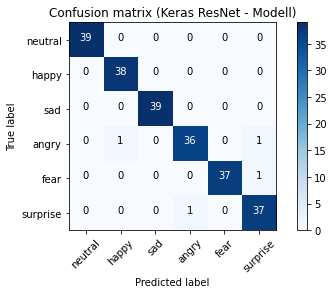

Fold score (accurancy): 0.9826086956521739
Finale score (accurancy): 0.840139009556907


In [20]:
oos_y = []
oos_pred = []
fold = 0

for train, test in kf.split(images, labels):
  fold+=1
  print(f"Fold #{fold}")

  x_train = images[train]
  y_train = labels[train]

  x_test = images[test]
  y_test = labels[test]
  history = model.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=50,        
            verbose=verbosity,
            validation_data = (x_test, y_test))
  y_pred = model.predict(x_test, batch_size=64, verbose=1)
  y_pred_b = np.argmax(y_pred, axis=1)

  print(classification_report(y_test, y_pred_b))
  
  plt.figure()
  plot_confusion_matrix(confusion_matrix(y_test, y_pred_b), classes=class_names)
  plt.show()

  pred = model.predict(x_test)

  oos_y.append(y_test)
  pred = np.argmax(pred,axis=1)
  oos_pred.append(pred)

  score = metrics.accuracy_score(y_test,pred)
  print(f"Fold score (accurancy): {score}")

oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)


score = metrics.accuracy_score(oos_y, oos_pred)
print(f"Finale score (accurancy): {score}")



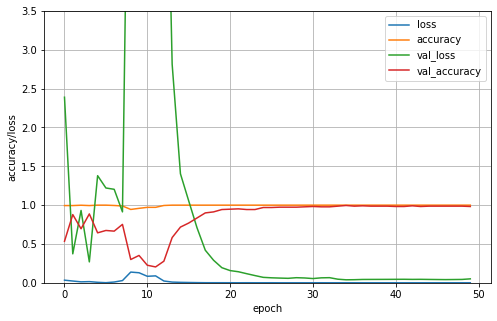

In [21]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.ylabel('accuracy/loss')
plt.xlabel('epoch')
plt.gca().set_ylim(0, 3.5)
plt.show()

## Save Modell<a class="anchor" id="#savemodell"></a>

In [27]:
model.save_weights(path_model)

In [8]:
new_model = build_model()
new_model.load_weights(path_model)

In [16]:
ravdess = PrecomputedRavdess(PATH_RAVDESS_TEST,
                                  img_transforms=transforms.Compose([transforms.ToTensor(),
                                                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225])]))
ravdess_loader_test = torch.utils.data.DataLoader(ravdess, bs, shuffle=True)

In [21]:
images_test, labels_test = next(iter(ravdess_loader_test)) 

In [22]:
# Datentyp-Umwandelung
images_test = (tf.cast(images_test, tf.float32) / 255).numpy()
labels_test = labels_test.numpy()

In [24]:
ps = new_model(images_test)